## NLP - Cory Wilson

### Part I: Research Question

#### A. Describe the purpose of this data analysis

#### Basic Setup

In [25]:
# Imports

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import nltk

from sklearn.model_selection import train_test_split

import tensorflow
from tensorflow import keras
from keras import preprocessing

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
import re

pd.set_option('display.max_colwidth',5000)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/thewilsons/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/thewilsons/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/thewilsons/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/thewilsons/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [26]:
# Creation of dataframe from the 3 seperate text files.
df_a = pd.read_csv('amazon_cells_labelled.txt',names=['review','label'],delimiter='\t', header=None)
df_i = pd.read_csv('imdb_labelled.txt',names=['review','label'],delimiter='\t', header=None)
df_y = pd.read_csv('yelp_labelled.txt',names=['review','label'],delimiter='\t', header=None)
df = pd.concat([df_a,df_i,df_y])

#### 1. Sumamrize one research question

Can customer sentiment be predicted from a review of a product? 

#### 2. Define goals or objectives of the data analysis.

The goal of this analysis will to be to determine if customer sentiment can be derived from a review. We will use a dataset of reviews from Amazon.com to build and test our model. This type of analysis could be crucial in customer service. It could aid customer service representatives in determining if a customer is happy or not and help them know how to reach out to to fix issues.

#### 3. Indentify neural network

The neural network being used for this analysis is a sequential network from the Keras library of Tensorflow. The type of model being used will be the sequential.

### Part II: Data Preparation

#### B. Summarize the data cleaning process

#### 1. Perform exploratory data analysis

In [27]:
df.describe()

,label
count,2748.000000
mean,0.504367
std,0.500072
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [28]:
# Drop the rows with missing values
df = df.dropna()
# Count the rows in the dataframe
len(df)


2748

In [29]:
# Check the shape of the dataframe
df.shape

(2748, 2)

/Users/thewilsons/miniforge3/envs/mlp/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

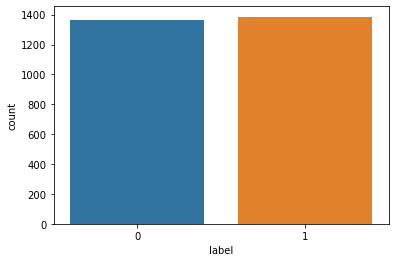

In [30]:
# Create a graph of the 'overall' column by count of each rating

sns.countplot(df['label'])

In [31]:
# Unusual Characters Discovery

list_of_characters = []
for review in df.review:
    for character in review:
        if character not in list_of_characters:
            list_of_characters.append(character)
print(list_of_characters)

['S', 'o', ' ', 't', 'h', 'e', 'r', 'i', 's', 'n', 'w', 'a', 'y', 'f', 'm', 'p', 'l', 'u', 'g', 'U', 'I', 'b', 'c', 'v', '.', 'G', 'd', ',', 'E', 'x', 'j', 'T', '4', '5', 'M', 'A', 'J', 'O', 'R', 'P', 'B', 'L', '!', 'z', 'N', 'W', 'q', 'H', '+', 'V', '"', 'Y', 'D', 'F', 'k', "'", 'K', 'C', '/', '7', '3', '6', '8', '0', '2', '?', 'Z', '-', '1', ':', ')', '(', 'Q', '&', '$', '*', ';', 'X', '%', '9', '#', '[', ']', '\x96', '\t', '\n', 'é', '\x85', 'å', '\x97', 'ê']


In [32]:
# Vocabulary Size

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['review'])
print(f"The total number of different words used in the reviews is:", len(tokenizer.word_index)+1)

The total number of different words used in the reviews is: 5272


The vocabulary size of the model will be set at 6000.

The proposed word embedding length is 16. While the maximum sequence length will be set to 120.

#### 2. Describe the goals of the tokenization process.

Tokenization is a vital part of natural language processing. Simply put, it is the process of breaking sentences or words into simpler pieces or tokens. The main goal behind it is to make the data more suitable for machine learning. (Sucky, 2021)

In [9]:
stop_words = stopwords.words('english')

review_list = []
for words in df.review:
    words = re.sub("[^a-zA-Z]", " ", words)

    words = words.lower()

    words = nltk.word_tokenize(words)

    lemma = nltk.WordNetLemmatizer()
    words = [lemma.lemmatize(word) for word in words]

    words = [word for word in words if not word in stop_words]
    words = " ".join(words)
    review_list.append(words)

In [10]:
# Add the review_list array from above to the existing datafram
df['review_list']=review_list
df.head()

# Rearranging and dropping the review column.
df = df[['review_list','label']]
df.head()

,review_list,label
0,way plug u unless go converter,0
1,good case excellent value,1
2,great jawbone,1
3,tied charger conversation lasting minute major problem,0
4,mic great,1


In [11]:
# Spliting the data
X = df['review_list']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20, stratify=y)

In [12]:
# Setting variables
vocab_size = 6000
embedding_dim = 16
max_length = 120
trunc_type = 'post'
oov_tok = '<OOV>'
padding_type = 'post'

#### 3. Explain the padding process.

Padding, much like tokenization, is a crucial step in the natural language processing framework. Padding adds zeros to the beginning and the end of sequences to ensure that they are all the same length. This is necessary for the neural network to be able to process the data.

In this analysis, padding occurs after the text sequence. (Sucky, 2021)

In [13]:
sequenced = tokenizer.texts_to_sequences(X_train)

padded = pad_sequences(sequenced, maxlen = max_length, truncating=trunc_type)

testing_reviews = tokenizer.texts_to_sequences(X_test)

padded_testing_reviews = pad_sequences(testing_reviews, maxlen=max_length)

In [14]:
# Single Padded Sequence

padded[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,  305, 2144,  966, 3574, 1709,   37, 4579, 1447],
      dtype=int32)

#### 4. Identify how many categories of sentiment will be used.

Two categories of sentiment will be used in this analysis, positive and negative.

#### 5. Explain the steps used to prepare the data for analysis.

The steps to prepare the data for analysis are as follows:
- Create dataframe from text files
- Remove text that isn't words(emojis, numbers, etc)
- Change case of entire string to lower case
- Tokenize words
- Remove stop words
- Remove existing review column and replace with new tokenized review

#### 6. Provide a copy of the cleaned data set.

In [15]:
df.to_csv('Cleaned_dataset.csv',index=False)

### Part III: Network Architecture

In [16]:
# Setting up the model

model = keras.Sequential(
    [
        keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        keras.layers.GlobalAveragePooling1D(),
        keras.layers.Dense(6, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ]
)

model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

model.summary()

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           96000     
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 6)                 102       
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 96,109
Trainable params: 96,109
Non-trainable params: 0
_________________________________________________________________


2022-03-08 08:47:38.692794: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-08 08:47:38.693767: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [17]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=8,
    min_delta=0.001,
    mode='max'
)
training_labels_final = np.array(y_train)
testing_labels_final = np.array(y_test)

num_epochs = 20

history = model.fit(padded, training_labels_final, epochs=num_epochs, callbacks=[early_stopping] ,validation_data=(padded_testing_reviews, testing_labels_final))

Epoch 1/20


2022-03-08 08:47:40.494173: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-08 08:47:40.793715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


69/69 [==============================] - 2s 26ms/step - loss: 0.6932 - accuracy: 0.4950 - val_loss: 0.6928 - val_accuracy: 0.4964
Epoch 2/20
 1/69 [..............................] - ETA: 3s - loss: 0.6957 - accuracy: 0.3438

2022-03-08 08:47:42.625518: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


69/69 [==============================] - 1s 21ms/step - loss: 0.6923 - accuracy: 0.5200 - val_loss: 0.6923 - val_accuracy: 0.4964
Epoch 3/20
69/69 [==============================] - 1s 20ms/step - loss: 0.6910 - accuracy: 0.5423 - val_loss: 0.6918 - val_accuracy: 0.4964
Epoch 4/20
69/69 [==============================] - 1s 20ms/step - loss: 0.6897 - accuracy: 0.5532 - val_loss: 0.6902 - val_accuracy: 0.7473
Epoch 5/20
69/69 [==============================] - 1s 20ms/step - loss: 0.6867 - accuracy: 0.6115 - val_loss: 0.6873 - val_accuracy: 0.7273
Epoch 6/20
69/69 [==============================] - 1s 20ms/step - loss: 0.6791 - accuracy: 0.6724 - val_loss: 0.6817 - val_accuracy: 0.5982
Epoch 7/20
69/69 [==============================] - 1s 19ms/step - loss: 0.6679 - accuracy: 0.6742 - val_loss: 0.6739 - val_accuracy: 0.6236
Epoch 8/20
69/69 [==============================] - 1s 20ms/step - loss: 0.6522 - accuracy: 0.6961 - val_loss: 0.6650 - val_accuracy: 0.5800
Epoch 9/20
69/69 [======

#### C. Describe the type of network used.

#### 1. Provide the output of the model summary of the fuction from TensorFlow

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           96000     
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 6)                 102       
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 96,109
Trainable params: 96,109
Non-trainable params: 0
_________________________________________________________________


#### 2. Discuss the number of layers, the types of layers, and total number of parameters.

The model uses 4 layers. The first layer is an embedding layer, the second is a Global Average Pooling layer, the third is the hidden layer, and the fourth is a dense layer using the Sigmoid activation function. In the embedding layer there are a total of 3 parameters being called out: Vocabulary Size, embedding dimensions, and input length. (Saxena, 2021)

#### 3. Justify the choice of hyperparameters

- Activation Functions
The chosen activation fuctions used are the recitified linear unit and sigmoid fuctions. The relu function seems like a good fit for this problem, and since this is essentially a classification problem, the sigmoid function is a must.

- Number of Nodes per layer
In the hidden layer there are 6 nodes being used, while in the last layer only 1 node is used.

- Loss function
Binary Crossentropy is the loss function that was selected for this problem.

- Optimizer
Adam is the optimizer of choice for this analysis.

- Stopping Criteria
For the analysis we are using the validation accuracy as our variable to be watched. If no significant change occurs in 8 epochs the network will be stopped.

- Evaluation Metric
Accuracy has been chosen as the main evaluation metric. Accuracy is the most important type of evaluation when trying to determine sentiment, like this problem.

(Sucky, 2021)

### Part IV: Model Evaluation

#### D. Evaluate the model training process and its outcomes.

#### 1. Discuss the impact of using stopping criteria instead of using epochs.

Early stopping, when used, prevents loss from increasing. When in turn, running epochs past a certain point will actually cause loss to increase. The ability to customize early stopping allows a researcher to hone settings that matter to them. In terms of this model, Validation accuracy is being monitored rather than loss. The model would stop if no discernible improvement was seen in 8 prior epochs. 

Another benefit to using early stopping is resource management, rather than allowing a model to continue to run, early stopping saves resources that would otherwise have been in use without a need. (Saxena, 2021)

#### 2. Provide visulizations of the model's training process

<Figure size 432x288 with 0 Axes>

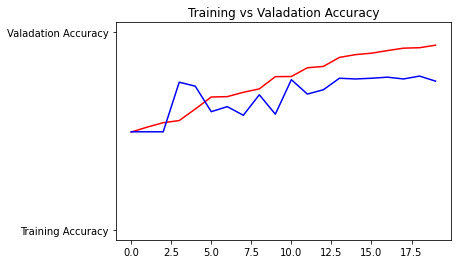

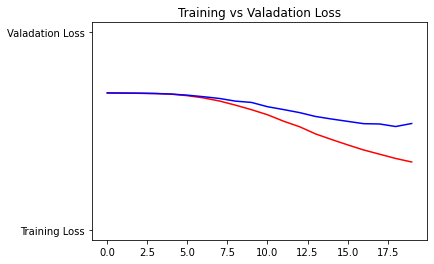

<Figure size 432x288 with 0 Axes>

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', 'Valadation Accuracy')
plt.title("Training vs Valadation Accuracy")
plt.figure()

plt.plot(epochs, loss, 'r', 'Training Loss')
plt.plot(epochs, val_loss, 'b', 'Valadation Loss')
plt.title("Training vs Valadation Loss")
plt.figure()

#### 3. Assess the fitness of the model

In [20]:
score = model.evaluate(padded_testing_reviews,testing_labels_final, verbose=0)
print(f'Test loss: {score[0]}/ Test accuracy: {score[1]}')

Test loss: 0.538329541683197/ Test accuracy: 0.7527272701263428


#### 4. Discuss the predictive accuracy of the trained network.

In [21]:
model.save('NLP_Analysis_Model.h5')

my_model = load_model('NLP_Analysis_Model.h5')

In [22]:
predictions = my_model.predict(padded_testing_reviews)

2022-03-08 08:48:53.060941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [23]:
i=510

print("Predicted review test: ", X_test[i], "\n")
print("Predicted:", "Negative" if predictions[i][0] >= 0.5 else "Positive", "review")
print("Actual: ","Negative" if y_test[i] == 0 else "Positive", "review")

Predicted review test:  much pasta love homemade hand made pasta thin pizza 

Predicted: Positive review
Actual:  Positive review


The model has an accuracy of .76. This translates to the model being roughly 76% accurate. Overall the model is accurate enough, with room for improvement. 

### Part V: Summary and Recommendations

#### E. Code

The code was created using Jupyter notebooks and utilized Python 3.8.12

#### F. Discuss the fuctionality of the neural network, including impact of network architecture.

The neural network featured in this analysis is highly fuctional and customizable. Tensorflow and Keras feature the ability to fine tune models through the use of layer structure, epochs, early stopping, and a variety of other variables. 

The way neural networks are structure allow them to be highly customizable and flexible in terms of problems they can solve. This problem is no different. The way this network has been structured can change and impact accuracy as a whole.

#### G. Recommend a course of action

An appropriate course of action at this time would be to continue to fine tune the model to achieve higher accuracy. With a more accurate model the company could then begin using it to reach out to customers with negative sentiments to try and remedy the problems they experienced. 

### Part VI: Reporting

### I. Third Party Code

Dr. Festus Elleh - Webex Meeting - Sunday, Feb. 27, 2022


Sucky, R. N. (2021, July 8). A complete step by step tutorial on sentiment analysis in Keras and tensorflow. Medium. Retrieved March 1, 2022, from https://towardsdatascience.com/a-complete-step-by-step-tutorial-on-sentiment-analysis-in-keras-and-tensorflow-ea420cc8913f 

Team, K. (n.d.). Keras Documentation: The sequential class. Keras. Retrieved March 3, 2022, from https://keras.io/api/models/sequential/ 

### J. References

Saxena, S. (2021, February 6). Understanding embedding layer in Keras. Medium. Retrieved March 8, 2022, from https://medium.com/analytics-vidhya/understanding-embedding-layer-in-keras-bbe3ff1327ce 

Sucky, R. N. (2021, July 8). A complete step by step tutorial on sentiment analysis in Keras and tensorflow. Medium. Retrieved March 1, 2022, from https://towardsdatascience.com/a-complete-step-by-step-tutorial-on-sentiment-analysis-in-keras-and-tensorflow-ea420cc8913f 